In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
from scipy.stats import gaussian_kde
import pyproj
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

# Plots of KL20 nereocystis

## set up

Directories

In [2]:
datadir = 'data/'
spdir = 'KL20_nereocystis/'
indir = 'output_byChr_byPop_params01/'
outdir = 'output_spacetrees/'
plotdir = 'plots/'

Sample locations

In [3]:
sample_locations = np.loadtxt(datadir + spdir + outdir + 'locations.txt')
n,d = sample_locations.shape

In [4]:
sample_extent = [min(sample_locations[:,1])-1,max(sample_locations[:,1])+1,min(sample_locations[:,0])-1,max(sample_locations[:,0])+1]

robinson_extent = [-141,-136,46,62] #got this by trial and error 

metadata

In [5]:
metadata_file = datadir + spdir + 'geographicCoords_KL20_nereocystis.txt'
metadata = []
with open (metadata_file,'r') as f:
    next(f)
    for line in f:
      for _ in range(2):
        metadata.append(line.split())

colors

In [6]:
colors = [i[5] for i in metadata]

In [7]:
colormap = {'aquamarine3': '#66CCDA', 'dodgerblue4': '#104E8B', 'lightskyblue1': '#B0E2FF', 'mediumorchid4': '#D15FEE', 'olivedrab': '#6B8E23', 'plum': '#DDA0DD', 'steelblue2': '#BCD2EE', 'NA': 'gray'}

sample locations colored by structure group

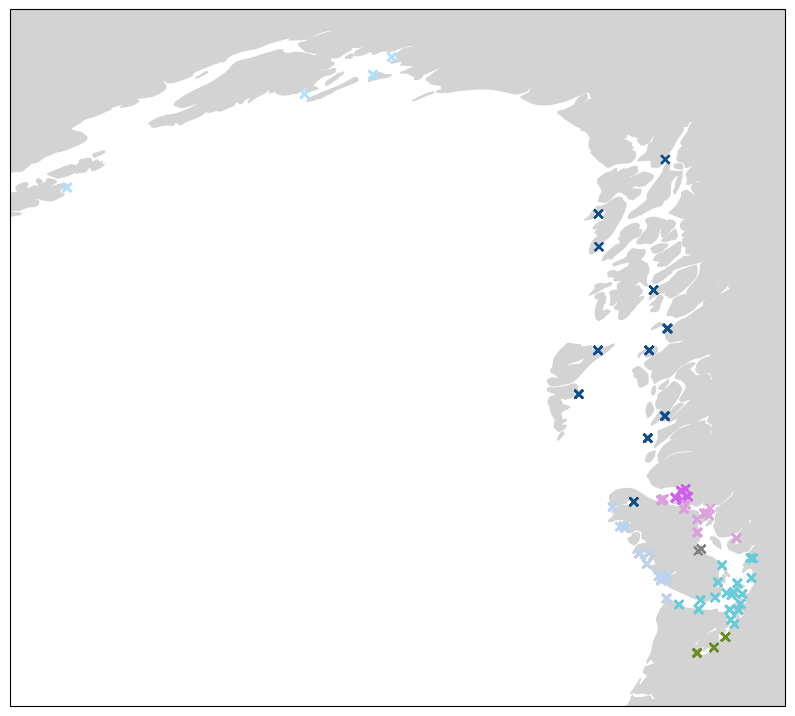

In [8]:
fig = plt.figure(figsize=(10,10))

projection = ccrs.Robinson()
data_crs = ccrs.PlateCarree() #data supplied in lat/long


ax = plt.axes(projection=projection)
ax.add_feature(cfeature.LAND, color='lightgray')

ax.scatter(sample_locations[:,1], sample_locations[:,0], transform=data_crs, color=[colormap[c] for c in colors], marker='x')
# ax.scatter(np.mean(sample_locations[:,1]), np.mean(sample_locations[:,0]), transform=data_crs, color='k', marker='o')
ax.set_extent(robinson_extent, crs=data_crs)

plt.show()

chromosomes (1 is a sex chromosome so excluded from relate)

In [9]:
CHRS = [str(i).zfill(2) for i in range(2,41)]

number of trees per chromosome (to use at top of Snakefile)

In [10]:
num_trees = []
for CHR in CHRS:
    with open(datadir + spdir + indir + 'JARUPZ0100000%s.1_popsize_params01.anc' %CHR) as f:
        next(f)
        num_trees.append(int(next(f).split()[1]))

In [11]:
np.array(num_trees)

array([28118, 16956, 16553, 13043, 12361, 15495, 14149,  6627, 13012,
       15276, 15903, 10979, 10614,  9554, 14752,  8389, 13377, 12746,
       13122, 11878,  8490, 13872, 10678,  4481,  7429, 13211,  7009,
        8018,  8866,  6670,  7125,  8714,  6758,  6866,  4611,  5982,
        3568,  1999,  5012])

Ancestor locations

In [13]:
fns = [fn for fn in sorted(glob.iglob(datadir + spdir + outdir + 'JARUPZ0100000*.blup_locs'))]
locs = np.array([np.loadtxt(fn, delimiter=',') for fn in fns])
L = len(locs)
T = int(locs.shape[1]/n)
ancestor_times = locs[0,:T,1]
anc_locs = locs[:,:,-2:].reshape(L,n,T,d)
anc_locs.shape

(60, 898, 10, 2)

In [14]:
ancestor_times

array([1.0e+01, 1.0e+02, 1.0e+03, 5.0e+03, 1.0e+04, 2.0e+04, 4.0e+04,
       8.0e+04, 1.6e+05, 3.2e+05])

## all ancestors

In [53]:
def all_ancestors(time_ix,extent=robinson_extent,samples=range(n),figsize=(5,5)):
    
    fig = plt.figure(figsize=figsize)
    projection = ccrs.Robinson()
    data_crs = ccrs.PlateCarree() #data supplied in lat/long
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.LAND, color='lightgray')

    # all ancestors at given time
    all_locs = []
    for sample in samples:
        locs = anc_locs[:, sample, time_ix]
        all_locs.append(locs)
    all_locs = np.vstack(all_locs)

    ax.scatter(all_locs[:, 1], all_locs[:, 0], c=np.repeat([colormap[c] for c in colors],L), s=3, marker='o', alpha=0.01, zorder=0, transform=data_crs)
    
    ax.set_extent(extent)
    ax.text(0.5, 1.01, '%d generations ago' % int(ancestor_times[time_ix]), ha='center', fontsize=14, transform=ax.transAxes)
    
    plt.tight_layout()
    # plt.savefig(plotdir + 'wohns_4b.png')
    plt.show()

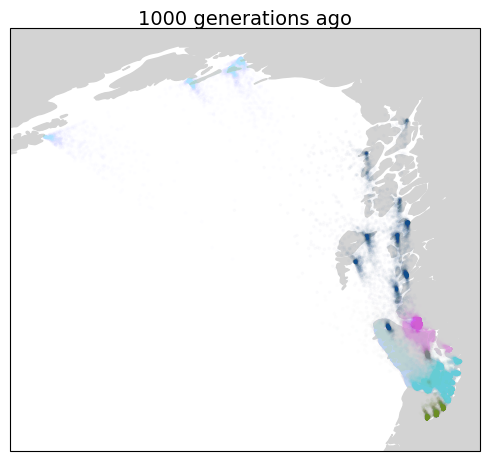

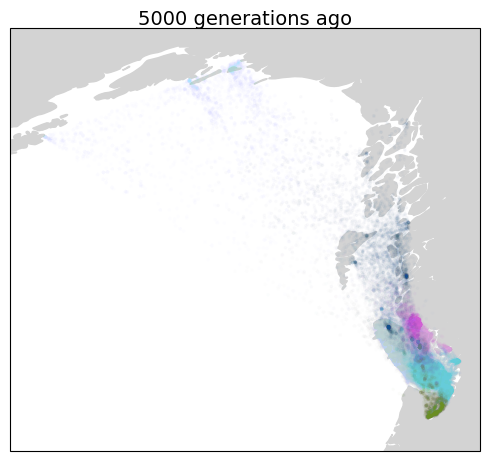

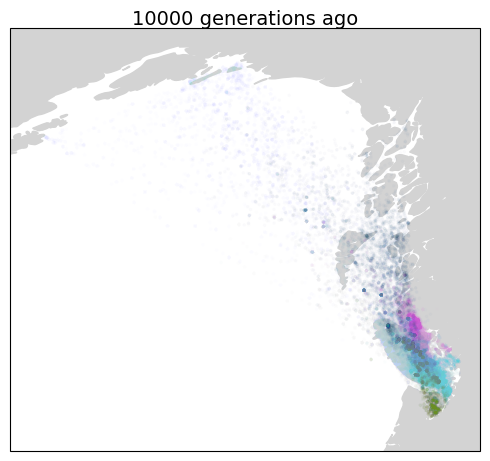

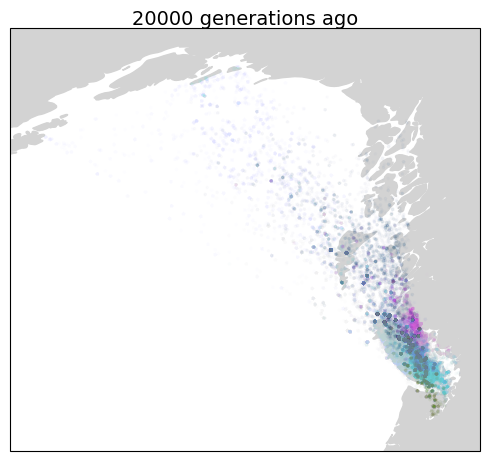

In [54]:
for i in [2,3,4,5]:
    all_ancestors(i)

## mean trajectories

In [27]:
def mean_trajectories(time_ixs,m=10,extent=robinson_extent,samples=range(n),figsize=(5,5)):
    
    fig = plt.figure(figsize=figsize)
    projection = ccrs.Robinson()
    data_crs = ccrs.PlateCarree() #data supplied in lat/long
    geodetic = ccrs.Geodetic() #for great circles
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.LAND, color='lightgray')
    cmap = plt.get_cmap("plasma_r")

    maxtime = ancestor_times[max(time_ixs)]
    
    for sample in samples: #for each sample
    
        prev_time = 0
        prev_mean_loc = sample_locations[sample]
        for time_ix in time_ixs:
            time = ancestor_times[time_ix]
            mean_loc = np.mean(anc_locs[:,sample,time_ix], axis=0)
            xs, ys, ts = np.linspace(prev_mean_loc[1],mean_loc[1],m), np.linspace(prev_mean_loc[0],mean_loc[0],m), np.linspace(prev_time,time,m) #linear interpolation
            for i in range(1,m):
                ax.plot([xs[i-1],xs[i]], [ys[i-1],ys[i]], color=cmap(ts[i]/maxtime), lw=1, alpha=0.5, transform=geodetic)
            prev_time = time
            prev_mean_loc = mean_loc

    ax.scatter(sample_locations[:,1], sample_locations[:,0], transform=data_crs, color=[colormap[c] for c in colors], marker='x')
    ax.scatter(np.mean(sample_locations[:,1]), np.mean(sample_locations[:,0]), transform=data_crs, color='k', marker='o', zorder=1e5) #mean sample location
    
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, orientation='horizontal', pad=0.01, shrink=0.9)
    cbar.set_ticks(np.linspace(0,1,6))
    cbar.set_ticklabels([int(i) for i in np.linspace(0,maxtime,6)])
    cbar.set_label(('generations ago'), fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    ax.set_extent(extent)
    
    plt.tight_layout()
    # plt.savefig(plotdir + 'wohns_4b.png')
    plt.show()

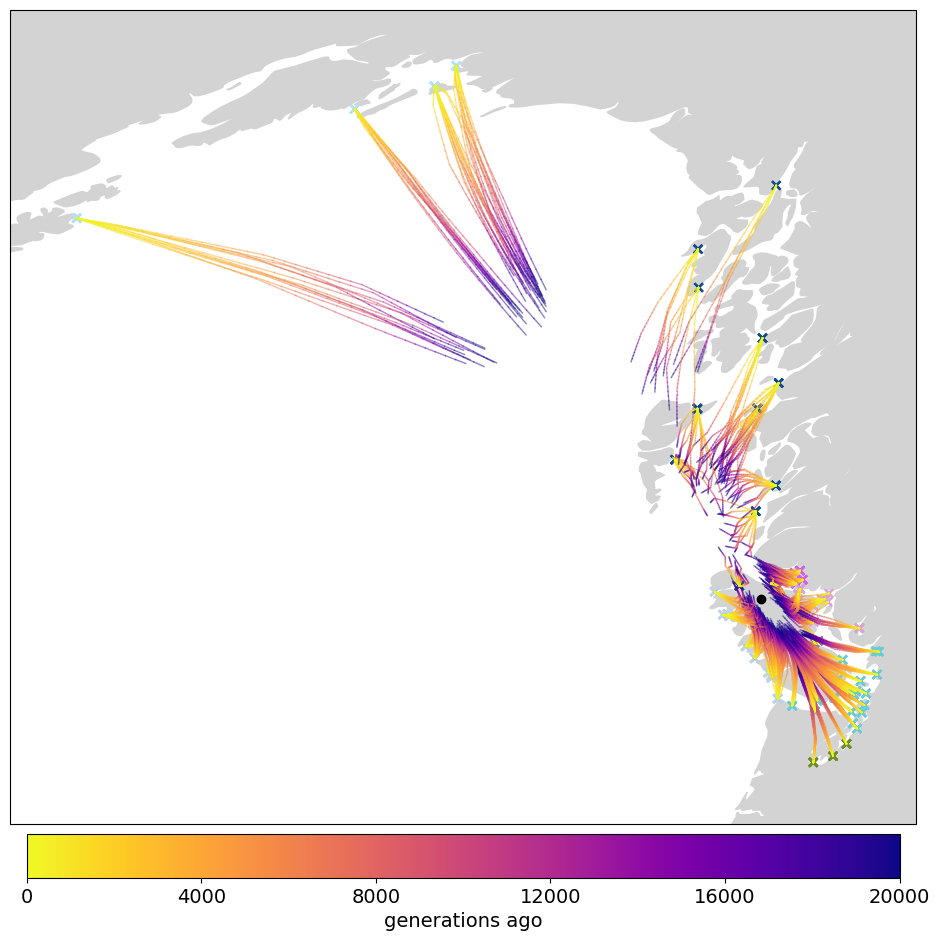

In [29]:
mean_trajectories(samples = range(n), time_ixs=range(len(ancestor_times)-4), figsize=(10,10))

## densities

In [23]:
def density_plot(time_ix,samples=range(n),extent=robinson_extent,figsize=(5,5)):

    fig = plt.figure(figsize=figsize)

    projection = ccrs.Robinson()
    data_crs = ccrs.PlateCarree() #data supplied in lat/long
    
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.LAND, color='lightgray')
        
    # all ancestors at given time
    all_locs = []
    for sample in samples:
        locs = anc_locs[:, sample, time_ix]
        all_locs.append(locs)
    all_locs = np.vstack(all_locs)
    
    # estimate density
    xy = np.vstack([all_locs[:, 1], all_locs[:, 0]])
    kde = gaussian_kde(xy, bw_method=0.1) 
    z = kde(xy)

    # plot density
    sc = ax.scatter(all_locs[:, 1], all_locs[:, 0], c=z, s=5, marker='o', cmap='viridis', alpha=0.5, zorder=0, transform=data_crs)

    # text
    ax.text(0.5, 1.01, '%d generations ago' % int(ancestor_times[time_ix]), ha='center', fontsize=14, transform=ax.transAxes)

    ax.set_extent(extent)

    plt.tight_layout()
    # plt.savefig(plotdir + 'wohns_4c.png')
    plt.show()

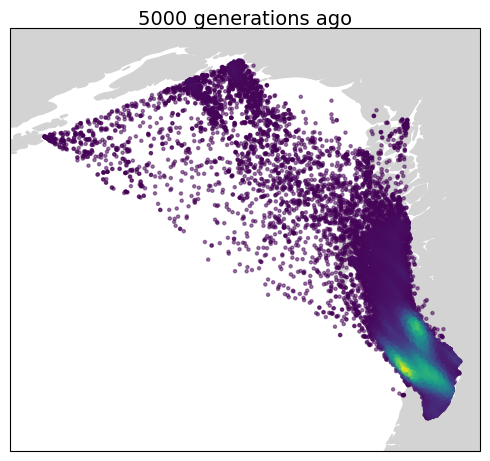

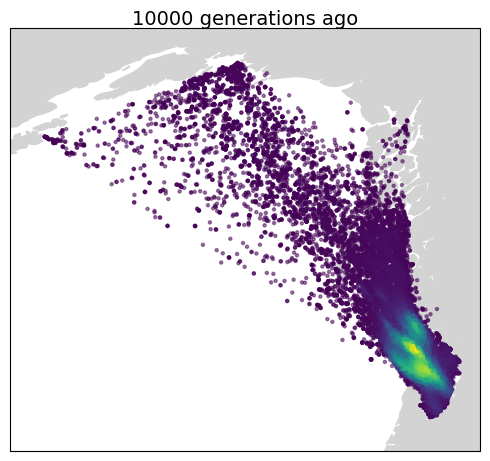

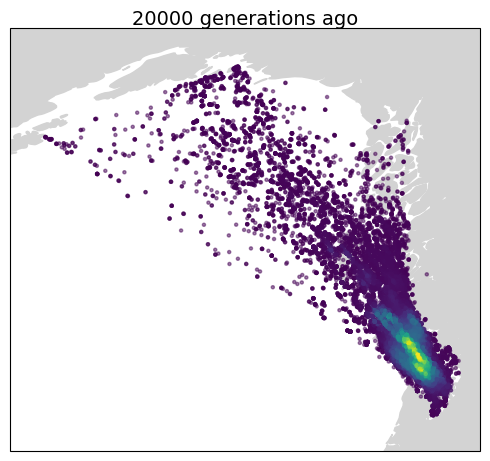

In [24]:
for i in [3,4,5]:
    density_plot(i)

In [25]:
def hex_density(time_ix,samples=range(n),extent=robinson_extent,figsize=(5,5)):

    fig = plt.figure(figsize=figsize)
    
    projection = ccrs.Robinson()
    data_crs = ccrs.PlateCarree() #data supplied in lat/long
    cmap = plt.get_cmap("Reds")
    
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.LAND, color='lightgray')

    # locations of all ancestors of all samples at this time
    all_locs = []
    for sample in samples:
        all_locs.append(anc_locs[:, sample, time_ix])
    all_locs = np.vstack(all_locs) 

    # histogram
    binlims = ax.projection.transform_points(data_crs, np.array(extent[:2]), np.array(extent[-2:])) 
    # ax.hexbin(x=all_locs[:,0], y=all_locs[:,1], transform=data_crs, cmap=cmap, gridsize=[30,10], alpha=0.5, extent=[binlims[0,0], binlims[1,0], binlims[0,1], binlims[1,1]])
    ax.hexbin(x=all_locs[:,1], y=all_locs[:,0], transform=data_crs, cmap=cmap, gridsize=[35,20], extent=[binlims[0,0], binlims[1,0], binlims[0,1], binlims[1,1]], alpha=0.5, mincnt=1)


    text = '%d generations ago' %int(ancestor_times[time_ix])
    ax.text(0.5,1.01,text,transform = ax.transAxes, ha='center', fontsize=14)

    ax.set_extent(extent)
    # ax.set_extent([xlims[0],xlims[1],ylims[0],ylims[1]], crs=data_crs)
    
    plt.tight_layout()
    # plt.savefig(plotdir + 'grundler_4.png')
    plt.show()

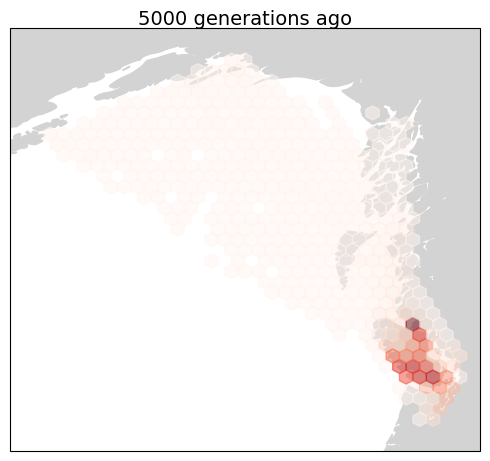

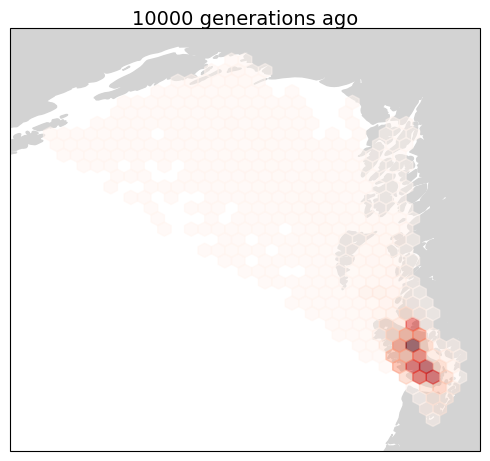

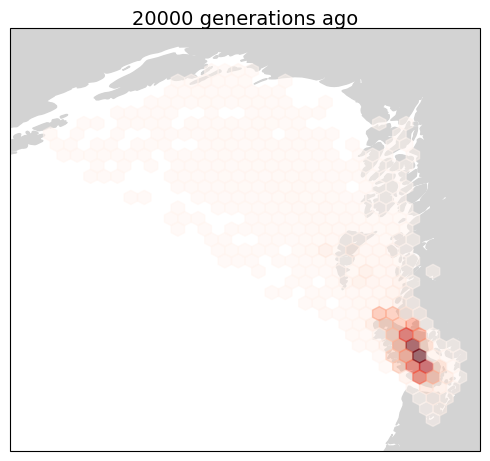

In [26]:
for i in [3,4,5]:
    hex_density(i)

## contours

In [105]:
def contours(time_ix,extent=robinson_extent,samples=[range(n)],colors=[plt.cm.tab10(0)],figsize=(5,5)):
    
    fig = plt.figure(figsize=figsize)
    projection = ccrs.Robinson()
    data_crs = ccrs.PlateCarree() #data supplied in lat/long
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.LAND, color='lightgray')

    # all ancestors of group at given time
    for i,group in enumerate(samples):
        all_locs = []
        for sample in group:
            locs = anc_locs[:, sample, time_ix]
            all_locs.append(locs)
        all_locs = np.vstack(all_locs)

        sns.kdeplot(x=all_locs[:, 1], y=all_locs[:, 0], transform=data_crs, ax=ax, levels=10, color=colors[i], bw_adjust=1, zorder=0, linewidths=1)
        ax.scatter(all_locs[:, 1], all_locs[:, 0], color=colors[i], zorder=0, transform=data_crs, alpha=0.1,s=5)
    
    ax.set_extent(extent)
    ax.text(0.5, 1.01, '%d generations ago' % int(ancestor_times[time_ix]), ha='center', fontsize=14, transform=ax.transAxes)
    
    plt.tight_layout()
    # plt.savefig(plotdir + 'wohns_4b.png')
    plt.show()

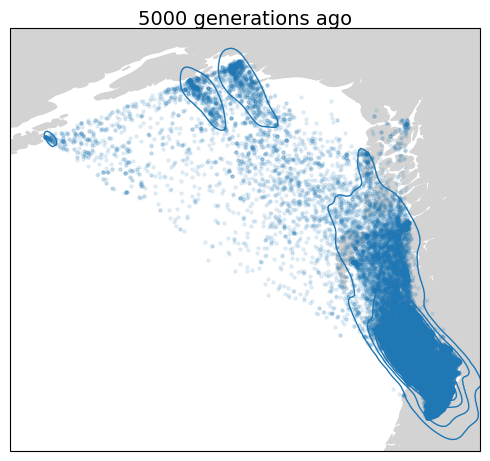

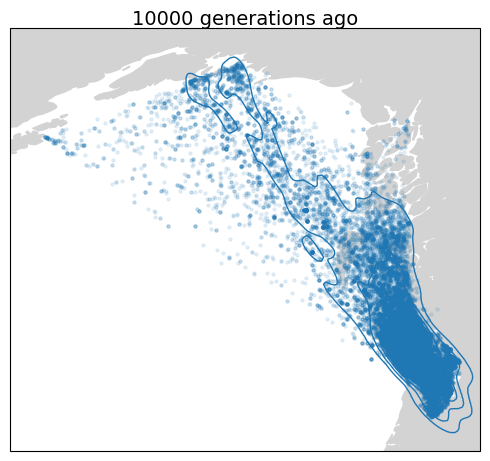

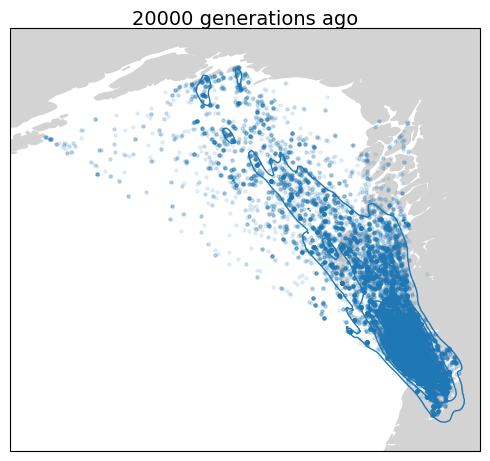

In [86]:
for i in [3,4,5]:
    contours(i,samples=[range(n)])

In [96]:
popid = np.unique(np.array(metadata)[:,2], return_inverse=True)[1]

In [108]:
popgroups = []
popcolors = []
for i in range(max(popid)+1):
    popgroups.append([j for j,p in enumerate(popid) if p==i])
    popcolors.append(colors[popgroups[i][0]])

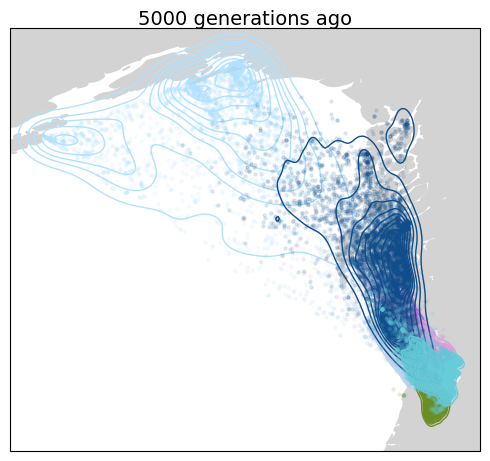

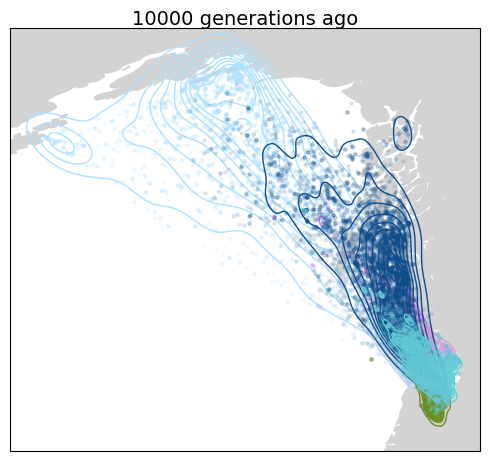

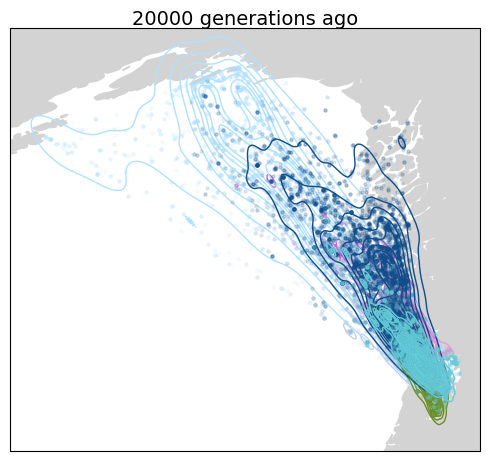

In [111]:
for i in [3,4,5]:
    contours(i,samples=popgroups,colors=[colormap[c] for c in popcolors])

## windroses

In [81]:
def polar_plot(bearings, ax=None, n=36, color='k', windrose_alpha=0.5):

    bins = np.arange(n + 1) * 360 / n
    width =  2 * np.pi / n

    frequencies, division = np.histogram(bearings, bins=bins, density=True)
    division = division[:-1]
    xs = division * np.pi / 180
        
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = plt.axes(polar=True)
        
    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')
    ax.patch.set_alpha(windrose_alpha)
        
    bars = ax.bar(xs, frequencies, width=width, align='center', zorder=2, edgecolor='k', linewidth=0.5, alpha=0.7, color=color)
#     sns.kdeplot(x=bearings* np.pi / 180, ax=ax, fill=True, color=color, bw_adjust=0.5)
#     ax.set_ylabel(None)

    # ax.set_yticklabels(labels=[])
    # ax.set_xticklabels(labels=[])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_rticks([])
    
def windrose(groups, extent=None, time_ix=-1, filename=None, figsize=(5,15), windrose_size=0.5, windrose_alpha=0.5):
    
    # set up plot
    fig = plt.figure(figsize=figsize)
    projection = ccrs.PlateCarree()
    data_crs = ccrs.PlateCarree() #data supplied in lat/long
    geodetic = ccrs.Geodetic() #for great circles
    # projection._threshold = projection._threshold/100.  #set finer threshold for smoother great circle lines
    ax = plt.axes(projection=projection)

    for group in groups:
    
        # get ancestor locations
        all_locs = []
        for sample in group:
            locs = anc_locs[:, sample, time_ix]
            all_locs.append(locs)
        all_locs = np.vstack(all_locs) 
    
        # plot the displacement at each locus as great circle
        # for loc in all_locs:
        #     lons = np.vstack([sample_locations[sample,1],loc[1]])
        #     lats = np.vstack([sample_locations[sample,0],loc[0]])
        #     ax.plot(lons, lats, transform=geodetic, alpha=0.5, color=plt.cm.tab10(0))
    
        # windrose inset
        geodesic = pyproj.Geod(ellps='WGS84')
        L,d = all_locs.shape
        bearings = np.zeros(L)
        distances = np.zeros(L)
        for i,(lat,long) in enumerate(all_locs):
            az1,_,d = geodesic.inv(sample_locations[sample,1],sample_locations[sample,0], long, lat)
            if az1 < 0:
                az1 = 360 + az1
            bearings[i] = az1
            distances[i] = d
        inset_ax = inset_axes(ax, width=windrose_size, height=windrose_size,
                              bbox_to_anchor=(sample_locations[sample,1],sample_locations[sample,0]), bbox_transform=ax.transData, 
                               loc='center', axes_class=matplotlib.projections.get_projection_class('polar'))
        polar_plot(ax=inset_ax, bearings=bearings, color=plt.cm.tab10(0))

    ax.add_feature(cfeature.LAND, color='lightgray')
    if extent is not None:
        ax.set_extent(extent, crs=data_crs)
    
    # plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)

    plt.show()

In [27]:
metadata = []
with open(datadir + 'KL14_nereocystis/geographicCoords_KL14_nereocystis.txt') as f:
    next(f)
    for line in f:
        metadata.append(line.split())

In [28]:
pops, pop_ix = np.unique([i[1] for i in metadata], return_inverse=True)

In [29]:
groups = []
for i,pop in enumerate(pops):
    group = []
    for j in range(n):
        if pop_ix.repeat(2)[j]==i:
            group.append(j)
    groups.append(group)

In [87]:
xlims = np.array([min(sample_locations[:,1])-1,max(sample_locations[:,1])+1])
ylims = np.array([min(sample_locations[:,0])-1,max(sample_locations[:,0])+1])
extent = [xlims[0],xlims[1],ylims[0],ylims[1]] 

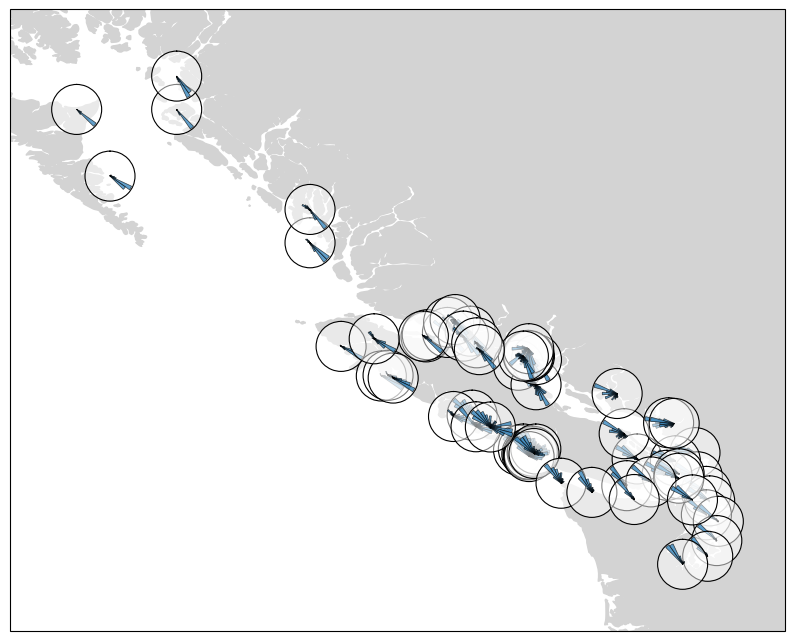

In [89]:
windrose(groups, figsize=(10,10), windrose_size=0.5, windrose_alpha=0.1, extent=extent)